In [1]:
from preamble import *
%matplotlib inline

# Algorithm Chains and Pipelines

In [2]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale training data
X_train_scaled = scaler.transform(X_train)

svm = SVC(C=100)
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
svm.score(X_test_scaled, y_test)

0.965034965034965

### Parameter Selection with Preprocessing 

In [4]:
from sklearn.grid_search import GridSearchCV
# illustration purposes only, don't use this code
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
grid.score(X_test_scaled, y_test)

0.97202797202797198

### Building Pipelines

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

In [6]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [7]:
pipe.score(X_test, y_test)

0.965034965034965

### Using Pipelines in Grid-searches

In [8]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.97202797202797198

In [10]:
grid.best_params_

{'svm__C': 1, 'svm__gamma': 1}

In [11]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [12]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print(X_selected.shape)

(100, 500)


In [14]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge
np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))

0.90579530652398221

In [15]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)), ("ridge", Ridge())])
np.mean(cross_val_score(pipe, X, y, cv=5))

-0.24655422384952805

### The General Pipeline Interface

In [18]:
def fit(self, X, y):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = step[1].fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [19]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # fit the last step
    return self.steps[-1][1].predict(X_transformed)

### Convenient Pipeline creation with ``make_pipeline``

In [20]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [21]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1',
  StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca', PCA(copy=True, n_components=2, whiten=False)),
 ('standardscaler-2',
  StandardScaler(copy=True, with_mean=True, with_std=True))]

#### Accessing step attributes

In [23]:
# fit the pipeline defined above to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print(components.shape)

(2, 30)


#### Accessing attributes in grid-searched pipeline.

In [24]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [25]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [27]:
print(grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [28]:
print(grid.best_estimator_.named_steps["logisticregression"])

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [29]:
print(grid.best_estimator_.named_steps["logisticregression"].coef_)

[[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


### Grid-searching preprocessing steps and model parameters

In [30]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [31]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [32]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

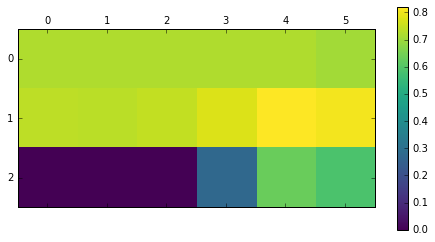

In [33]:
plt.matshow(np.array([s.mean_validation_score for s in grid.grid_scores_]).reshape(3, -1),
            vmin=0, cmap="viridis")
plt.colorbar()

In [34]:
print(grid.best_params_)

{'ridge__alpha': 10, 'polynomialfeatures__degree': 2}


In [35]:
grid.score(X_test, y_test)

0.76735803503061784

In [36]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.62717803817745799